# Model Evaluation Notebook

In [336]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
from dataset import Paint2CodeDataset
from utils import collate_fn, ids_to_tokens, generate_visualization_object, img_transformation
from models import Encoder, Decoder
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm
import pickle
from GUIconverter.GUIconverter import GUIconverter
from IPython.display import display, HTML, Image

In [337]:
# Configuration parameters
model_file_path = "./models/ED--epoch-24--loss-0.19261.pth"  
data_path = Path("data", "all_data")
use_cuda = True
img_crop_size = 224
split = "validation"
batch_size = 4
seed = 42

In [338]:
# Set random seeds for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Setup GPU
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
print(f"Using device: {device}")

# Ensure the model file exists
assert Path(model_file_path).exists(), "Model file path does not exist"

Using device: cuda


AssertionError: Model file path does not exist

In [ ]:
# Load the saved model
loaded_model = torch.load(model_file_path, map_location=device)
vocab = loaded_model["vocab"]

assert vocab is not None, "Vocabulary must be loaded."
len(vocab)

17

In [ ]:
# Initialize the models
embed_size = 256
hidden_size = 512
num_layers = 2

encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Load model weights
encoder.load_state_dict(loaded_model["encoder_model_state_dict"])
decoder.load_state_dict(loaded_model["decoder_model_state_dict"])

encoder.eval()
decoder.eval()
print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


In [ ]:
# Image transformations
transform_imgs = img_transformation(img_crop_size)

# Data loader
data_loader = DataLoader(
    Paint2CodeDataset(data_path, split, vocab, transform=transform_imgs),
    batch_size=batch_size,
    collate_fn=lambda data: collate_fn(data, vocab=vocab),
    pin_memory=True if use_cuda else False,
    drop_last=True)

In [ ]:
# Evaluate the model and calculate BLEU score
predictions = []
targets = []

for i, (image, caption) in enumerate(tqdm(data_loader.dataset)):
    image = image.to(device)
    caption = caption.to(device)
    features = encoder(image.unsqueeze(0))
    sample_ids = decoder.sample(features).cpu().data.numpy()
    
    predictions.append(ids_to_tokens(vocab, sample_ids))
    targets.append(ids_to_tokens(vocab, caption.cpu().numpy()))

bleu_score = corpus_bleu([[target] for target in targets], predictions, smoothing_function=SmoothingFunction().method4)
print(f"BLEU score: {bleu_score:.4f}")

100%|██████████| 339/339 [00:34<00:00,  9.84it/s]

BLEU score: 0.9258


In [ ]:
generate_visualization_object(data_loader.dataset, predictions, targets)
print("Visualization objects generated.")

PATH_VIS_OBJ = Path("tmp_sequenсes.pkl")

with open(PATH_VIS_OBJ, 'rb') as handle:
    viz_obj = pickle.load(handle)
    
predictions = viz_obj["predictions"]
targets = viz_obj["targets"]
targets_filepaths = viz_obj["targets_filepaths"]

assert predictions and targets and targets_filepaths

Visualization objects generated.


In [ ]:
def display_html_string(html_string):
    page = HTML(html_string)
    display(page)

def compare_results(predicted_labels, actual_labels, actual_img_path):
    transpiler = GUIconverter(style='style5')

    print(f'Predicted HTML. #tokens: {len(predicted_labels)}')
    predicted_html_string = transpiler.transpile(predicted_labels, insert_random_text=True)
    print(predicted_html_string)
    display_html_string(predicted_html_string)
    
    print(f'Actual image file')
    display(Image(str(actual_img_path))) 

Predicted HTML. #tokens: 55
<html>
  <header>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
<style>
.body { background-color: #DCF2F1; margin: 0px;}
.header { background-color: #012529; }
nav ul { list-style: none; padding: 10px; display: flex; border-radius: 4px;  }
nav ul li { padding: 10px; flex: 1; text-align: center; }
.column { float: left; padding: 20px; background-color: #c2e4ec; border-radius: 5px; margin: 10px 20px }
.column.half { width: 48%;  ; }
.column.full { width: 96%;  }
.column.quarter { width: 23%; }
.last { margin-right: 0; }
.clearfix { overflow: auto; display: flex; justify-content: center;  }
a.button { padding: 10px 15px;  background-color: #365486; color: white; border-radius: 4px; display: inline-block; text-decoration: none; }
a.button-header { padding: 10px 15px; margin: 10px 30px 10px 5px; background-color: #0F1035; color: white; border-radius: 4px; display: inline-block; text-decoration: none;}
</style>

Actual image file


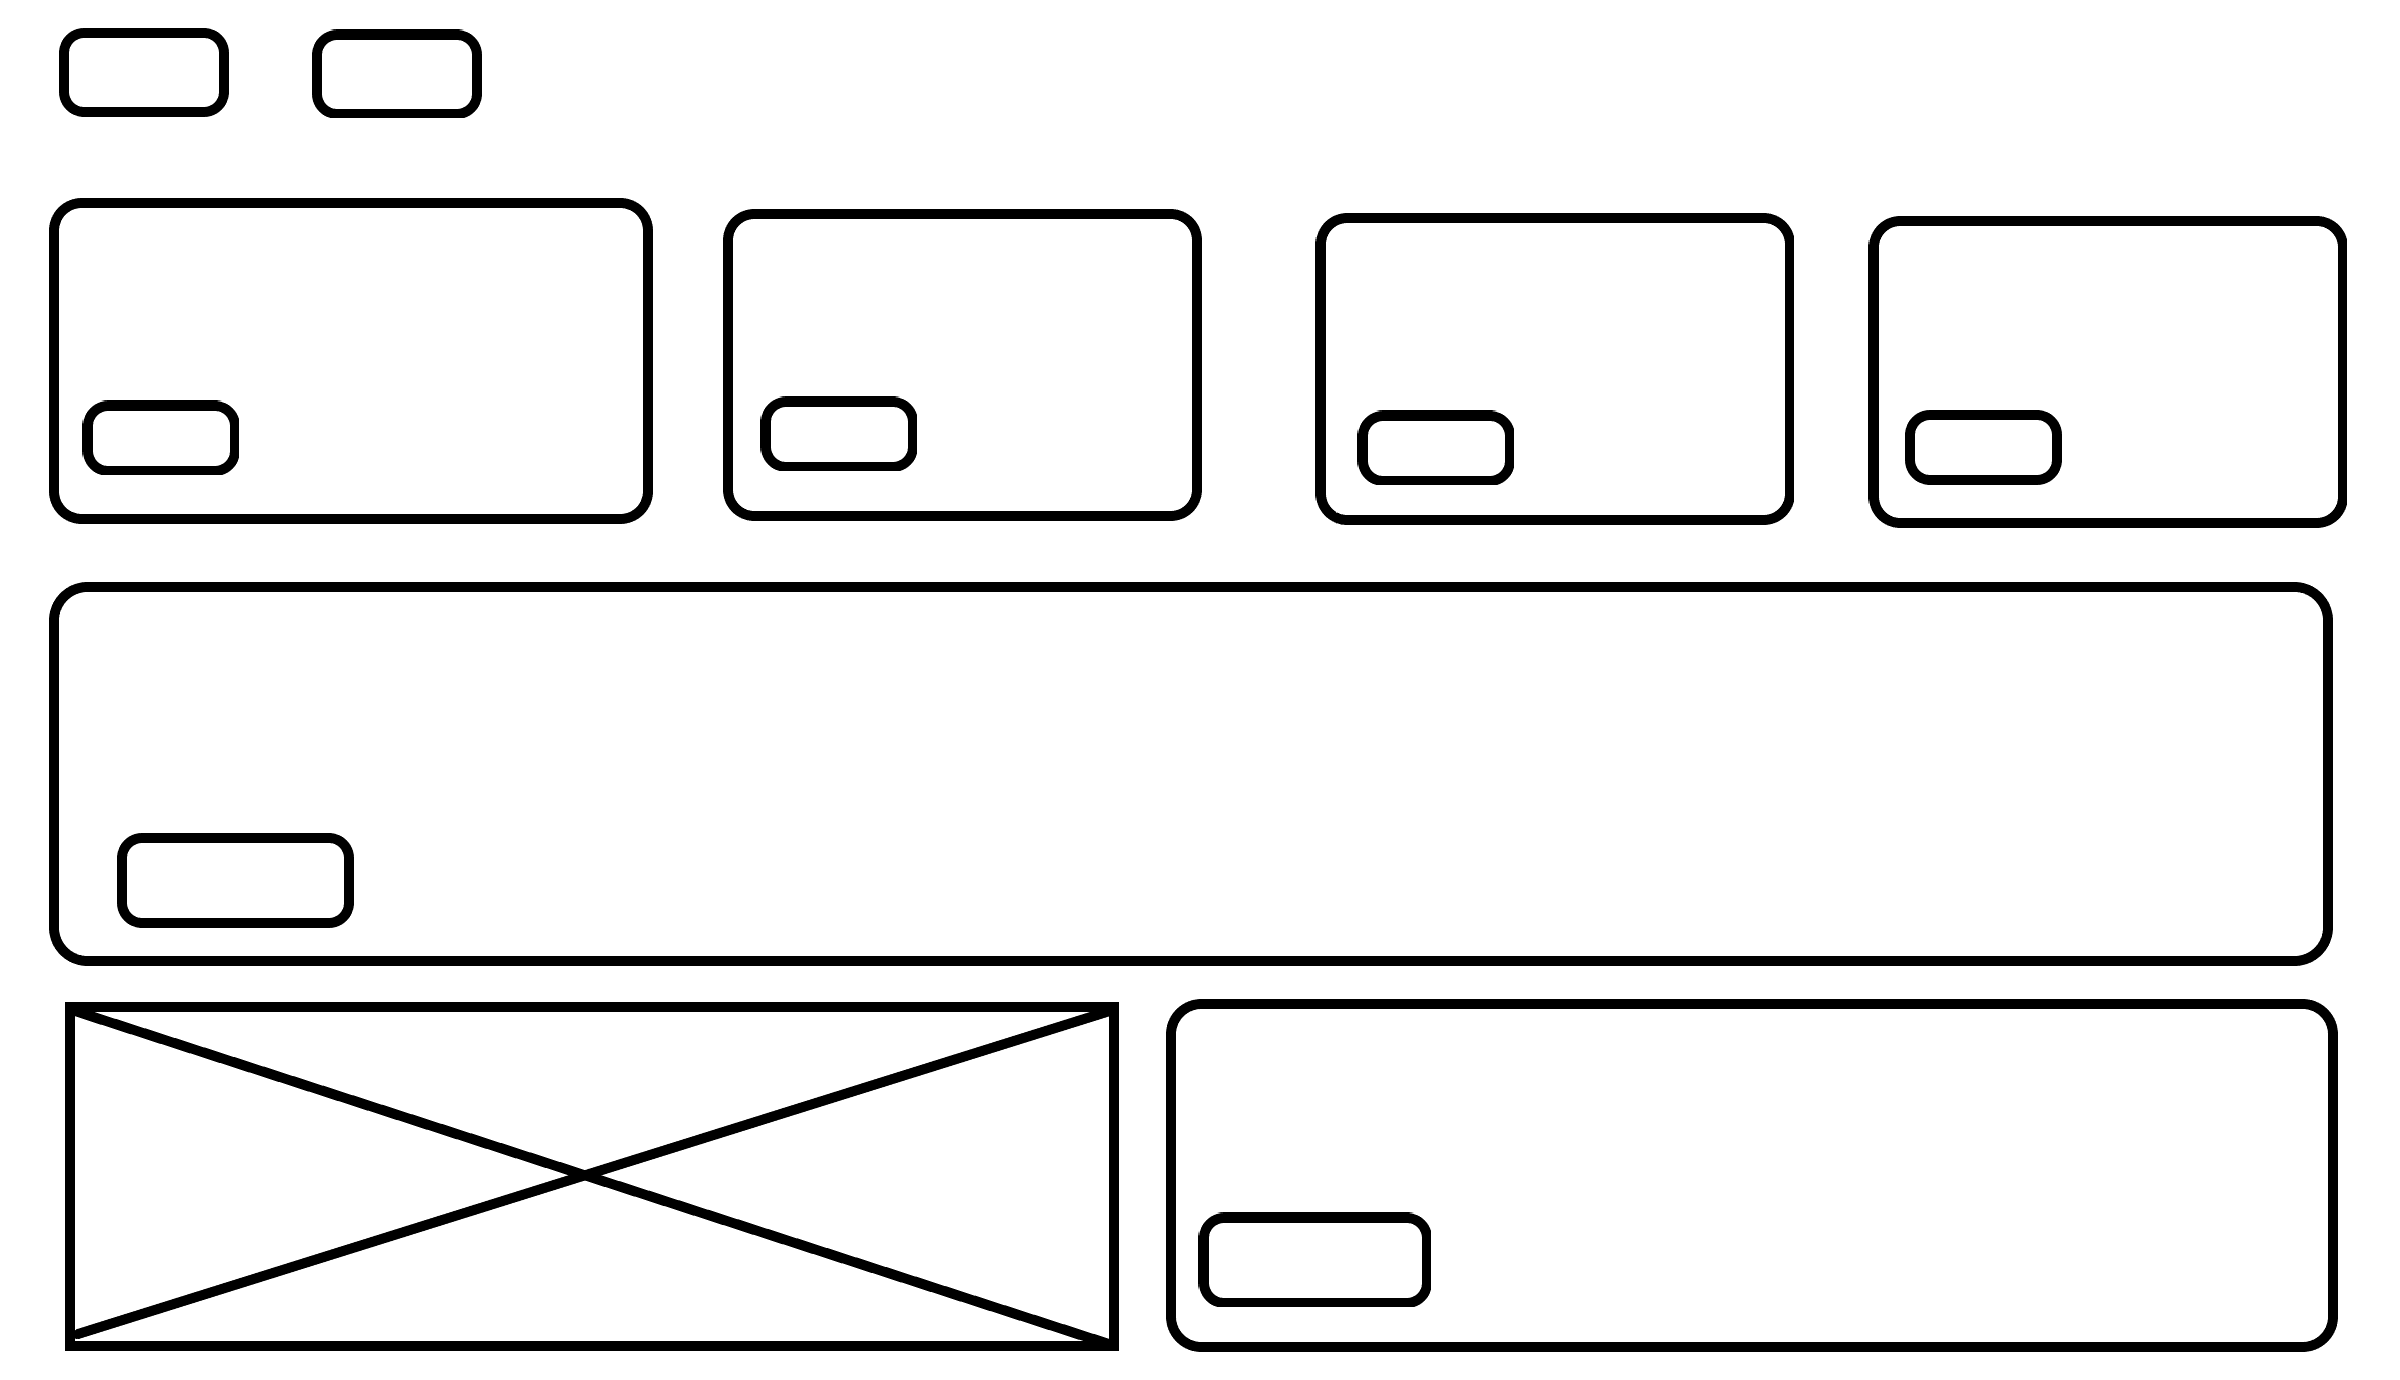

In [ ]:
# Change the following variable to test out different results
example_idx = 36
compare_results(predictions[example_idx], targets[example_idx], targets_filepaths[example_idx])